Ciclo Crisis 52-55 ignorado (fuera de rango)
Ciclo Expansión 56-69 ignorado (fuera de rango)
Ciclo Recesión 70-81 ignorado (fuera de rango)
Ciclo Crisis 82-84 ignorado (fuera de rango)


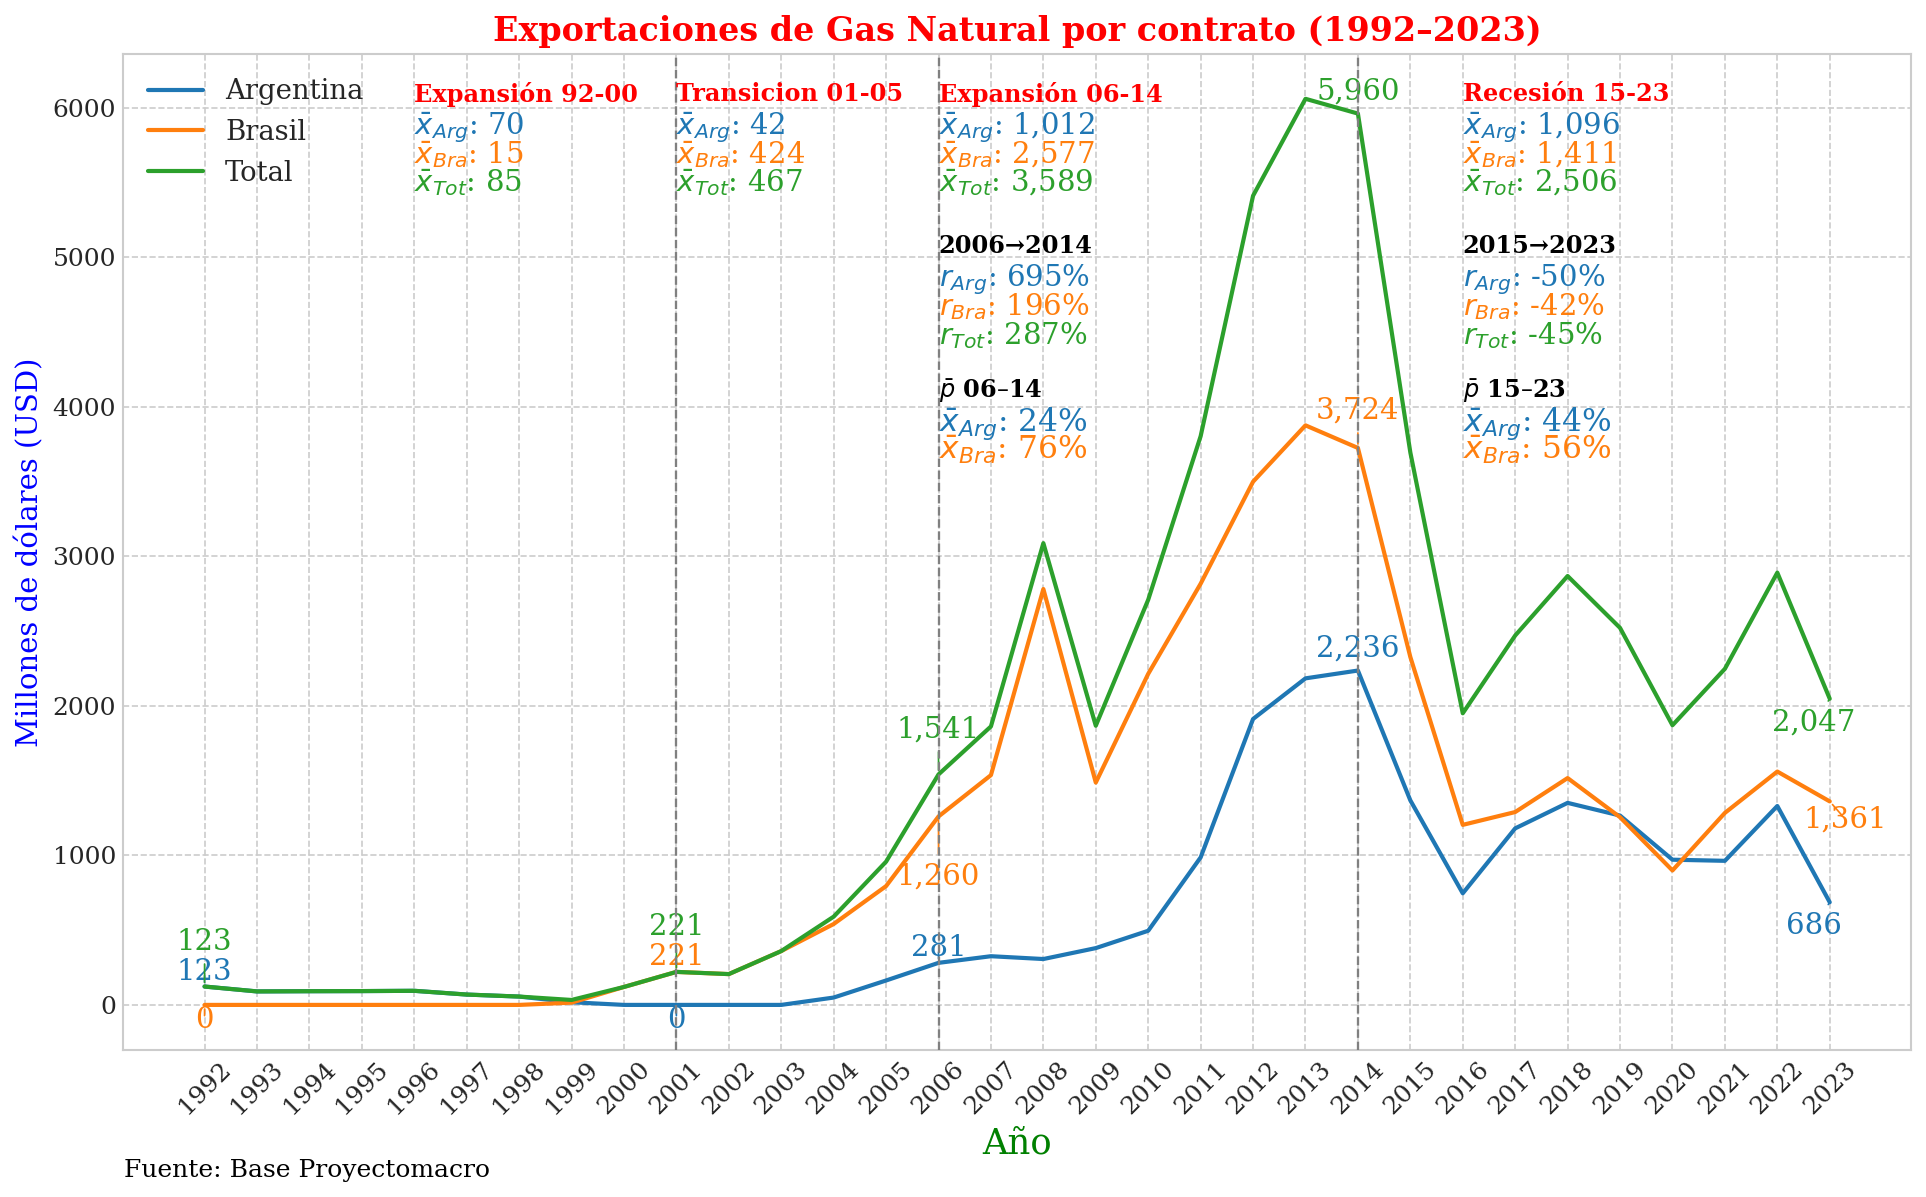

In [8]:
# ───────────────────────── 0. IMPORTS Y CONFIGURACIÓN GENERAL ─────────────────────────
import os, sys, sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# utilidades propias
sys.path.append(os.path.abspath('../'))
from graficos_utils import *
from config import *          # CYCLES, hitos_v, annot_years, periodos_tasas …

# Configuración general
output_dir = f"../../../../assets/tesis/serie_completa/exportaciones"
os.makedirs(output_dir, exist_ok=True)

set_style()                   # estilo único

# ───────────────────────────── 1. CARGA DE DATOS ─────────────────────────────
with sqlite3.connect("../../../../db/proyectomacro.db") as conn:
    df_raw = pd.read_sql(
        "SELECT año, destino, monto FROM exportacion_gas_natural_contratos",
        conn
    )

# Agrupamos y pivotamos
df = (df_raw.groupby(['año', 'destino'])['monto']
               .sum()
               .unstack(fill_value=0)
               .sort_index())
df['total'] = df.sum(axis=1)

# ──────────────── 2. COMPONENTES, COLORES Y ABREVIATURAS ────────────────
componentes = [
    ("Argentina", "Argentina"),
    ("Brasil",    "Brasil"),
    ("total",     "Total"),
]
cols_componentes = [c for c, _ in componentes]

cmap   = plt.get_cmap("tab10")
custom_colors = {col: cmap(i) for i, (col, _) in enumerate(componentes)}
abbr_componentes = {"Argentina": "Arg", "Brasil": "Bra", "total": "Tot"}

# ──────────────── 3. PREPARACIÓN ────────────────
cycles   = adjust_cycles(df, CYCLES)
annotate_years = adjust_annot_years(df, annot_years)      # (re)usa lista global
periodos = adjust_periods(df, periodos_tasas) # para tasas y growth
cycles_stats  = {name: df.loc[slc].mean().to_dict() for name, slc in cycles.items()}

# ──────────────── 4. OFFSETS ────────────────
hitos_offsets = {año: 0.67 for año in hitos_v}

annotation_offsets = {
    "Argentina": {
        1992: (0, 100),   # antes 1992 → ahora 1982
        2001: (0, -100),
        2006: (0, 100),
        1986: (0, 100),   # antes 2008 → ahora 1986
        2014: (0, 150),
        2023: (-0.3, -160),
    },
    "Brasil": {
        1992: (0, -100),
        2001: (0, 100),
        2006: (0, -400),
        1986: (0, 400),
        2014: (0, 250),
        2023: (0.3, -120),
    },
    "total": {
        1992: (0, 300),
        2001: (0, 300),
        2006: (0, 300),
        1986: (0, 300),
        2014: (0, 150),
        2023: (-0.3, -160),
    },
}

# Líneas de hitos (se mantiene la misma clave de hitos_v) :contentReference[oaicite:0]{index=0}
hitos_offset = {a: 0.8 for a in hitos_v}

# Cuadros de medias por ciclo (claves según CYCLES locales)
medias_offsets = {
    "Expansión 92-00":    (1996, 0.97),
    "Transicion 01-05":   (2001, 0.97),
    "Expansión 06-14":    (2006, 0.97),
    "Recesión 15-23":     (2016, 0.97),
}

# Tasas de crecimiento por periodo (claves según periodos_tasas) :contentReference[oaicite:1]{index=1}
tasas_offsets = {

    "2006-2014": (2006, 0.81),
    "2015-2023": (2016, 0.81),
}

# Participación promedio por periodo (mismas claves que tasas_offsets)
participation_offsets = {
    "2006-2014": (2006, 0.66),
    "2015-2023": (2016, 0.66),
}

# ───────────────────────────── 5. GRÁFICA ─────────────────────────────
fig, ax = init_base_plot(
    df=df,
    series=componentes,
    colors=custom_colors,
    title=f"Exportaciones de Gas Natural por contrato ({df.index[0]}–{df.index[-1]})",
    xlabel="Año",
    ylabel="Millones de dólares (USD)",
    source_text="Fuente: Base Proyectomacro",
    legend_ncol=1
)

# 5.1 Hitos verticales
add_hitos(ax, df.index, hitos_v, hitos_offsets)

# 5.2 Medias de ciclo
line_spacing = ax.get_ylim()[1] * 0.03
add_cycle_means_multi(ax, cycles_stats, medias_offsets, abbr_componentes, custom_colors, line_spacing)

# 5.3 Tasas de crecimiento
add_period_growth_annotations_multi(
    ax, df, periodos, cols_componentes, tasas_offsets, custom_colors, abbr_componentes,
    fmt="{vi}→{vf}: {tasa}%",
)

# 5.4 Anotaciones puntuales
add_year_value_annotations(
    ax, df, annotate_years, cols_componentes, annotation_offsets, custom_colors, arrow_lw=0.8
)

# 5.5 Cuadros de participación
add_participation_cycle_boxes(
    ax, df, periodos, ["Argentina","Brasil"], "total",
    participation_offsets, abbr_map=abbr_componentes, colors={c: custom_colors[c] for c in ["Argentina","Brasil"]}
)

plt.savefig(os.path.join(output_dir, "gas_natural_por_contrato.png"), dpi=300)
plt.show()